In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('figure', dpi=300)
from glob import glob
import sys
sys.path.insert(0,"/home/sourav/MapArt/edgeDet/HED/pytorch-hed/")
from edgeModule import *
sys.path.insert(0, "/home/sourav/MapArt/modules/")
#--------
from image_processing import *
from optim_map import *
#----------
from matplotlib.colors import LogNorm
from shapely.geometry import LineString
import geopandas as gpd
import osmnx as ox

import matplotlib.cm as cmap
import matplotlib.patches as patches


# Load Map data

In [3]:
yeg = FitTransform('yeg_20k.gpkg')

Will take while, go get a coffee!
Done loading the map data.


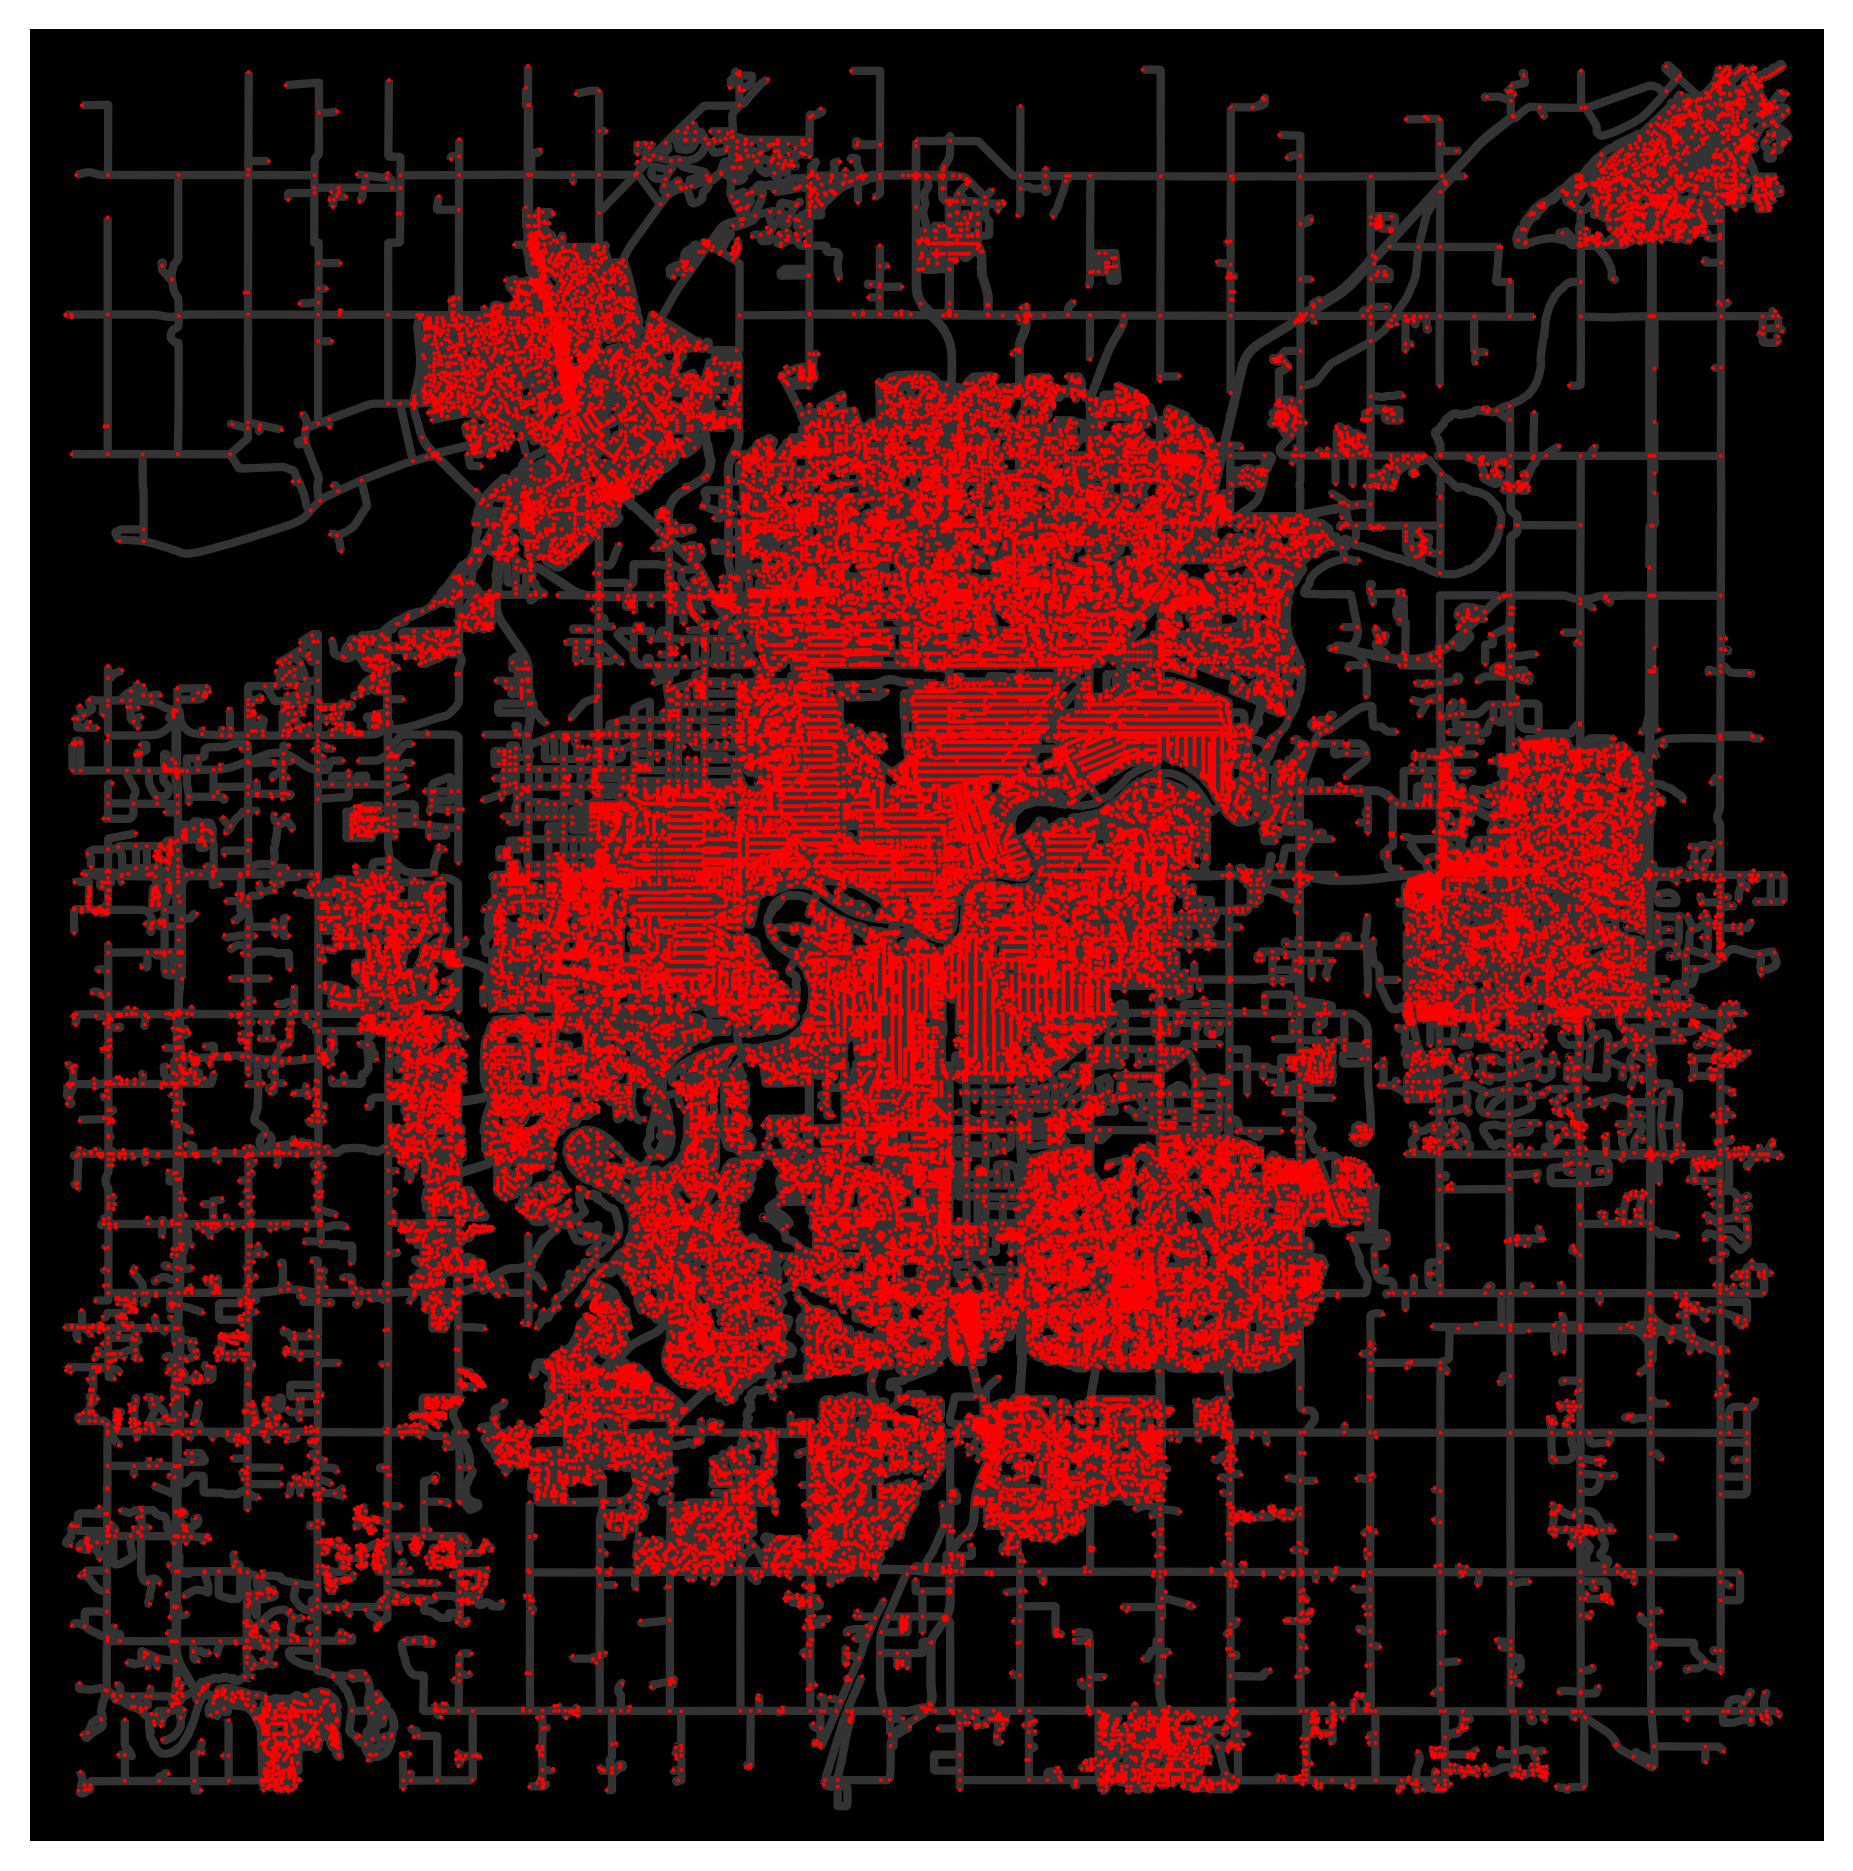

In [4]:
fig, ax = ox.plot_graph(
    yeg.graph, bgcolor="k", node_color='r', node_size=1, edge_linewidth=2, edge_color="#333333"
)


# Data I/O

In [6]:
datadir = "/home/sourav/MapArt/datasets/animals/animals/"
outdir = "/home/sourav/MapArt/datasets/inputs/"
animals = []
with open("/home/sourav/MapArt/datasets/input_animals.txt") as file:
    andirs = [line.rstrip() for line in file]
print (andirs)

imageList = []
for an in andirs:
    images = glob(datadir+an+'/*')
    imageList += images
    
datadir = "/home/sourav/MapArt/datasets/inputsv1/"
imageList = glob(datadir+"*")


['antelope', 'bat', 'bear', 'bee', 'bison', 'butterfly', 'cat', 'caterpillar', 'chimpanzee', 'cow', 'coyote', 'crow', 'deer', 'dog', 'dolphin', 'dragonfly', 'duck', 'eagle', 'elephant', 'flamingo', 'fox', 'goldfish', 'goose']


# Select an Image

In [7]:
#select a random image
imidx = np.random.choice(len(imageList))
#load and view the image
filename = imageList[imidx]
img0 = cv.imread(filename)
#plt.imshow(img0)
if not(Qfilter(img0)): 
    imageList.remove(filename)
    print ("Low quality image.")


In [60]:
filename = '/home/sourav/MapArt/datasets/inputsv1/6a3d93aed7.jpg'

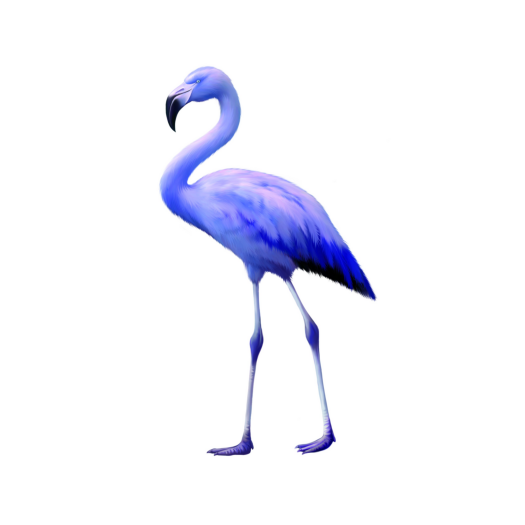

In [61]:
plt.figure().set_figwidth(2)
plt.imshow(cv.imread(filename))
plt.axis('off')
plt.show()

# Process Image

In [62]:
#initialize the image
improc = ImageProcessing(filename)
#apply threshold filter
improc.threshold_filter()
#perform scaling
improc.scale_image()
#perform knn filtering
improc.run_knn_filter()
#generate interpolator
improc.make_interpolator()
#get the binary bitmap
bimg = improc.binary_filter()

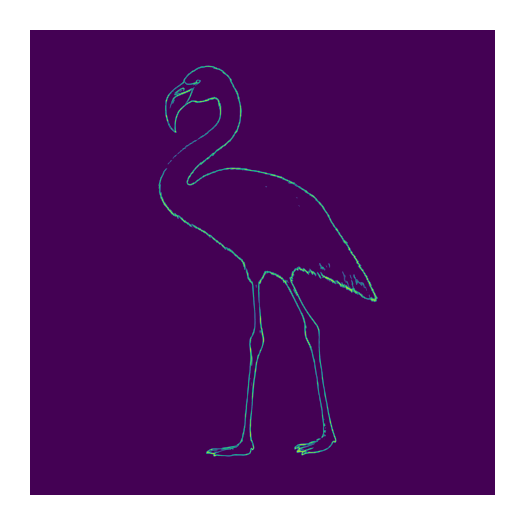

In [63]:
# Show cleaned image
plt.figure().set_figwidth(2)
plt.imshow(np.flipud(improc.imgEdge))
plt.axis('off')
plt.show()

In [64]:
imtrac = ImageTracing(bimg)
imtrac.apply_transform()
imtrac.apply_tracing()
rects = imtrac.rectangle_sq(improc, width=15, pad=5)

The image tracing produced 20 curves.
Negative:  0.0
Positive:  0.0
Negative:  0.0
Positive:  0.0


In [65]:
#check the scatter plot
x = improc.xcord.reshape(-1)
y = improc.ycord.reshape(-1)
z = improc.imgEdge.reshape(-1)

filtidx = np.where(z>0)[0]
num_pix = 1000
testidx = np.random.choice(filtidx, num_pix, replace=False)
# prepare a set of test points
testpoints = np.zeros(num_pix, dtype=[('x',float), ('y', float)])
testpoints['x'] = x[testidx]
testpoints['y'] = y[testidx]

# prepare the sequence of boxes
boxes = rects.copy()
keys = ['p1x', 'p1y', 'p2x', 'p2y',
       'p3x', 'p3y', 'p4x', 'p4y']

for key in keys:
    boxes[key] /= improc.scale_norm


# Map transfers

In [72]:
def fn_eval(x,y,fn):
    xidx = np.where(np.logical_or(x>1, x<0))[0]
    yidx = np.where(np.logical_or(y>1, y<0))[0]
    z = fn.ev(x,y)
    z[xidx] = 0.0
    z[yidx] = 0.0
    return z

In [75]:
scale = 0.2
shiftx = 1.8
shifty = 2
rot = -20*np.pi/180.

xt,yt = yeg.forward_transform(scale, shiftx, shifty, rot)
attr = fn_eval(xt,yt,improc.interpolator)

thr = 0.
filt = np.where(attr>thr)[0]

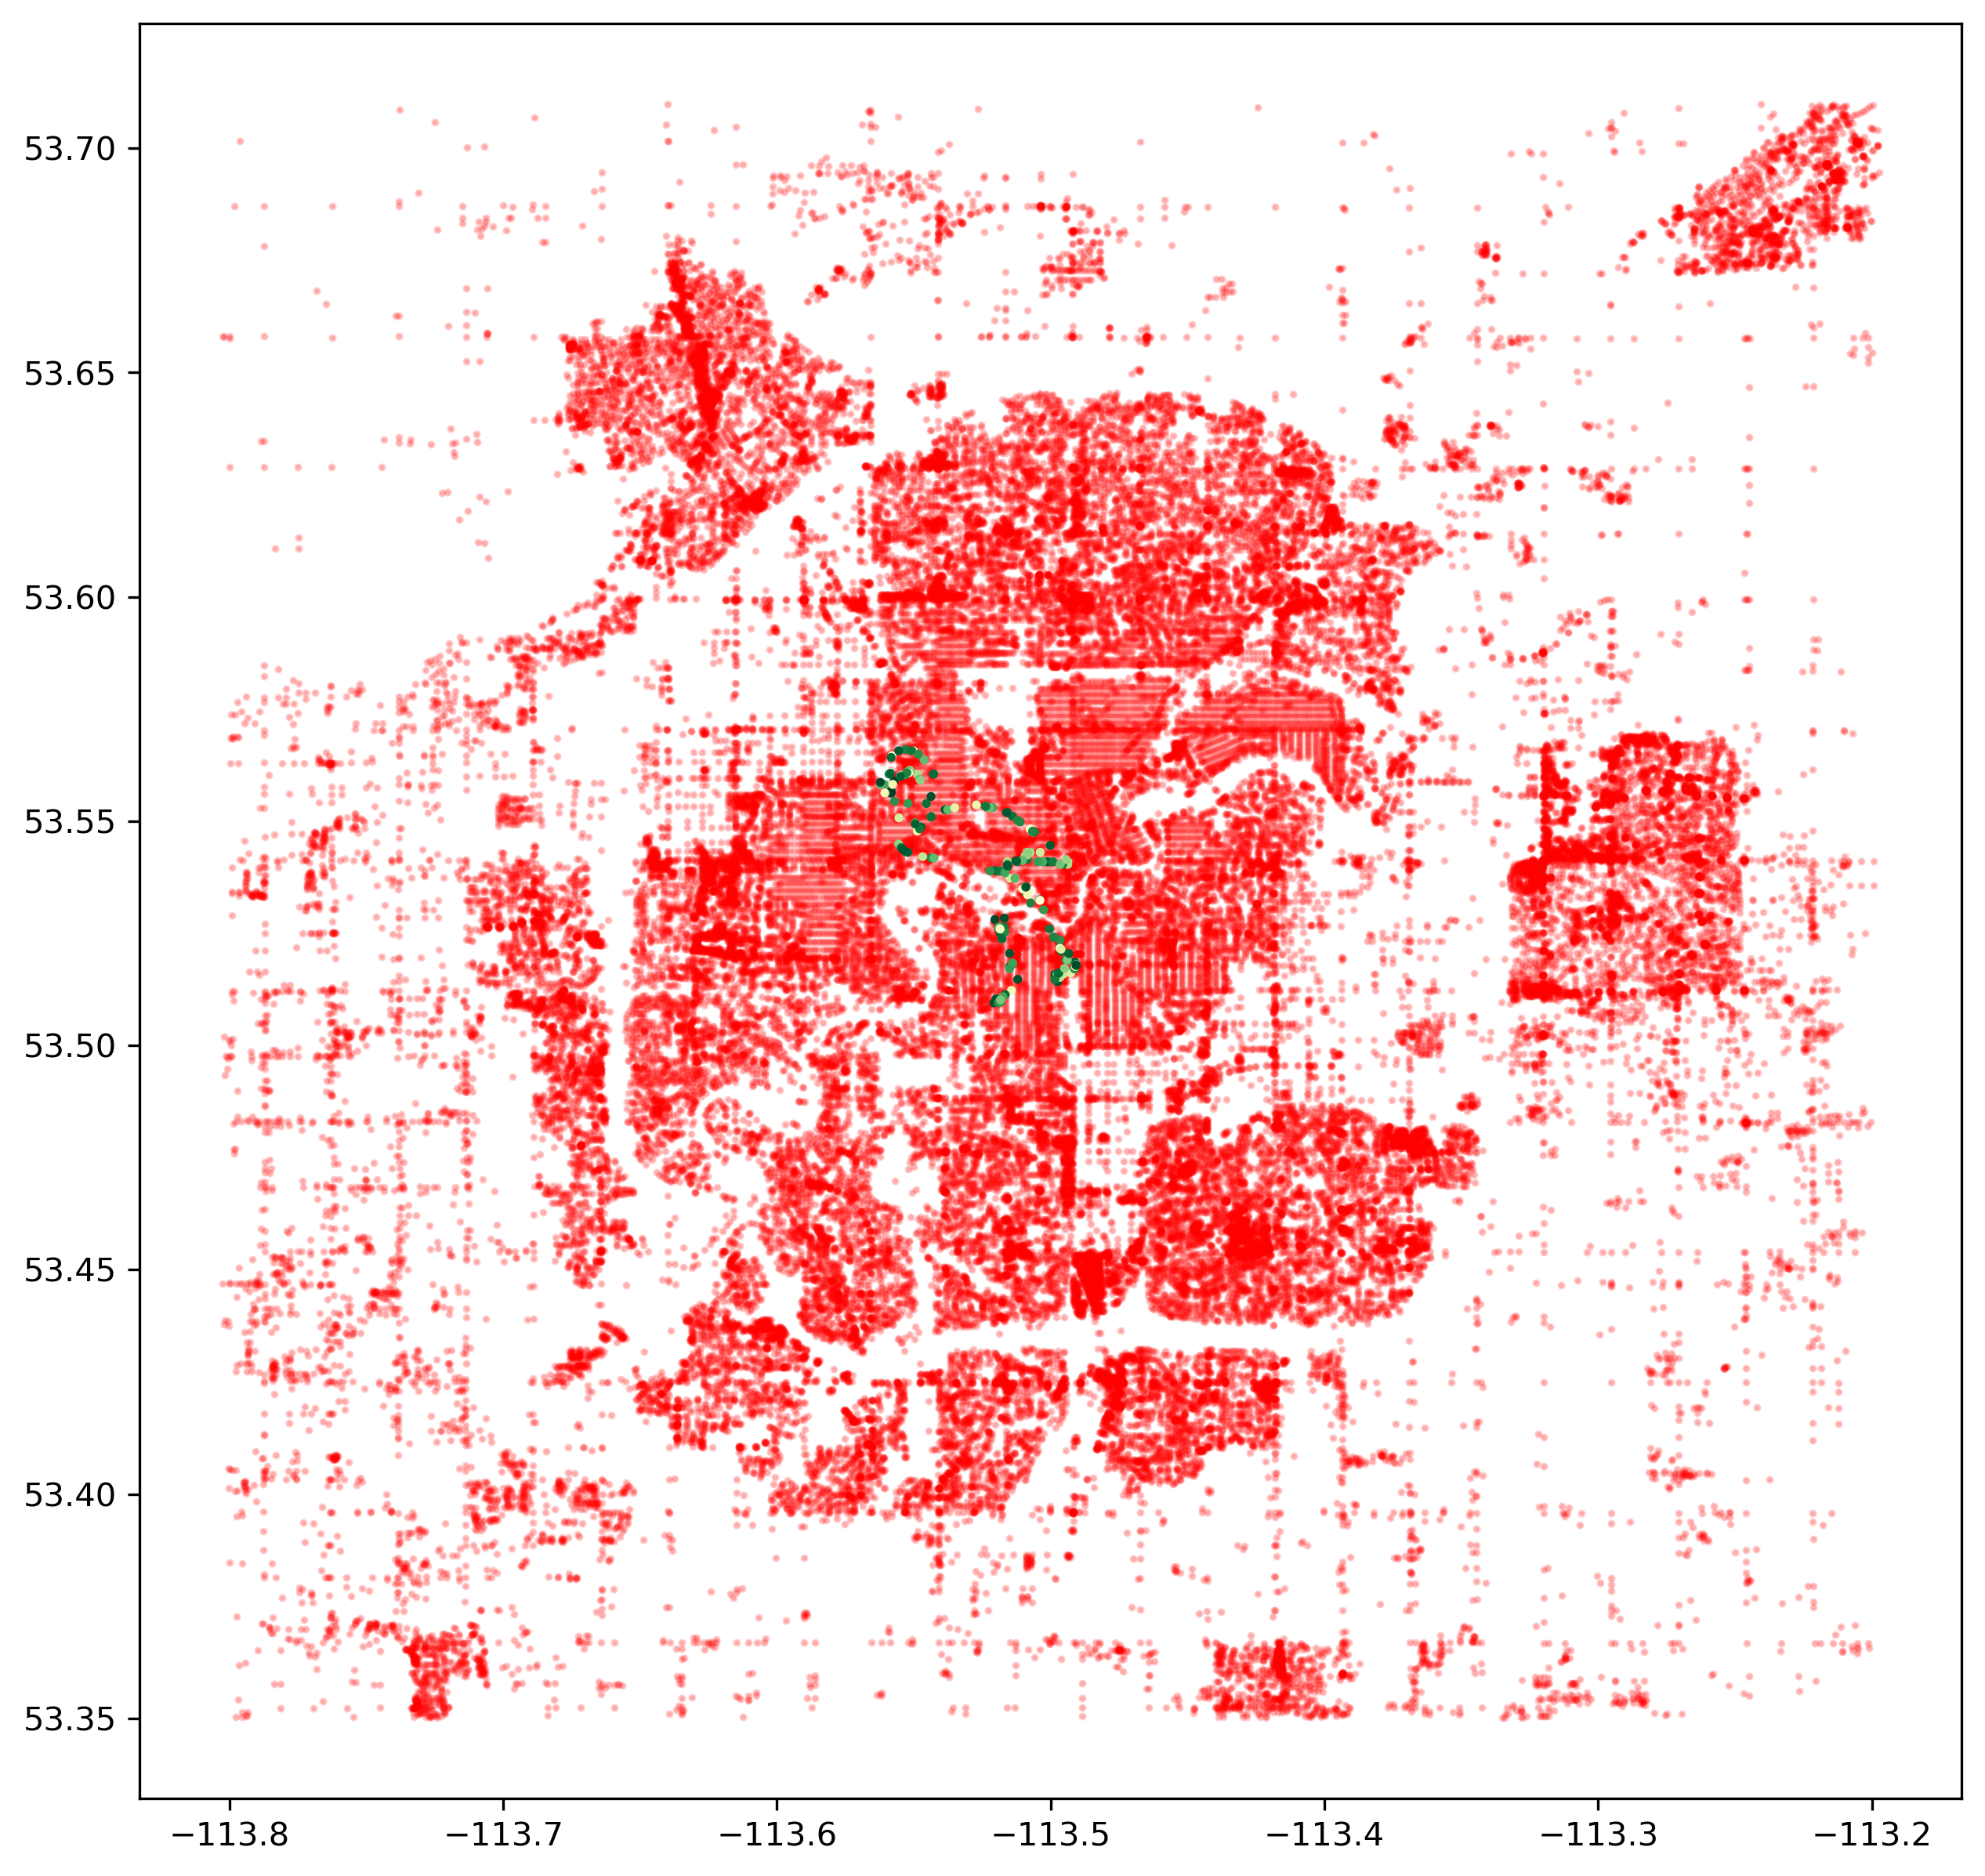

In [76]:
drawx = yeg.xmap[filt]
drawy = yeg.ymap[filt]


plt.figure(figsize=(10,10))
plt.scatter(yeg.xmap, yeg.ymap, s=2,alpha=0.2,c='r')
plt.scatter(drawx, drawy,
            c=attr[filt], s=3, cmap='YlGn')
#plt.xlim([min(drawx)-0.01, max(drawx)+0.01])
#plt.ylim([min(drawy)-0.02, max(drawy)+0.02])
plt.show()

In [71]:
#get only the drawing points
xt = xt[filt]
yt = yt[filt]

points = np.zeros(len(filt), dtype=[('x', float), ('y', float)])
points['x'] = xt
points['y'] = yt

In [53]:
seq = Sequencer(points, boxes)
seq.start_sequence(tolerance=15)

In [54]:
segs = []
tdict = seq.seq_dict
for key,val in tdict.items():
    #print (key)
    #print (len(val))
    arr = np.zeros((len(val), 2))
    point = val.head
    i=0
    if point.data is not None:
        arr[i,0] = points[point.data][0]
        arr[i,1] = points[point.data][1]
    #print (key)
    while point.next:
        i +=1
        point = point.next
        #print (point.data)
        arr[i,0] = points[point.data][0]
        arr[i,1] = points[point.data][1]
    segs.append(arr)
    #print (len(val))

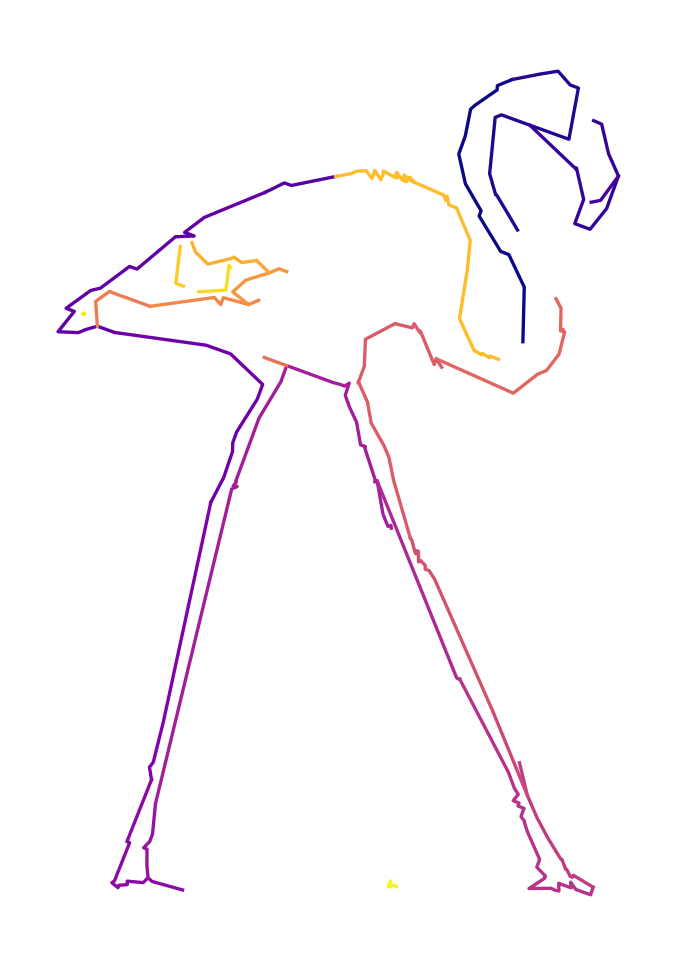

In [55]:
cmaps = cmap.plasma(np.linspace(0,1,len(segs)))
i=0
#plt.figure()
fig, ax = plt.subplots()

for s in segs:
    ax.plot(s[:,0], s[:,1], lw=0.8, color=cmaps[i])
    i+=1

#plt.xlim([0.3,0.5])
#plt.ylim([0,0.4])
ax.set_aspect(1)
plt.axis('off')

plt.show()

In [967]:
seg_ids = []
tdict = seq.seq_dict
for key,val in tdict.items():
    arr = []
    point = val.head
    arr.append(filt[point.data])
    while point.next:
        point = point.next
        arr.append(filt[point.data])
    arr = tuple(arr)
    seg_ids.append(arr)
    #print (len(val))

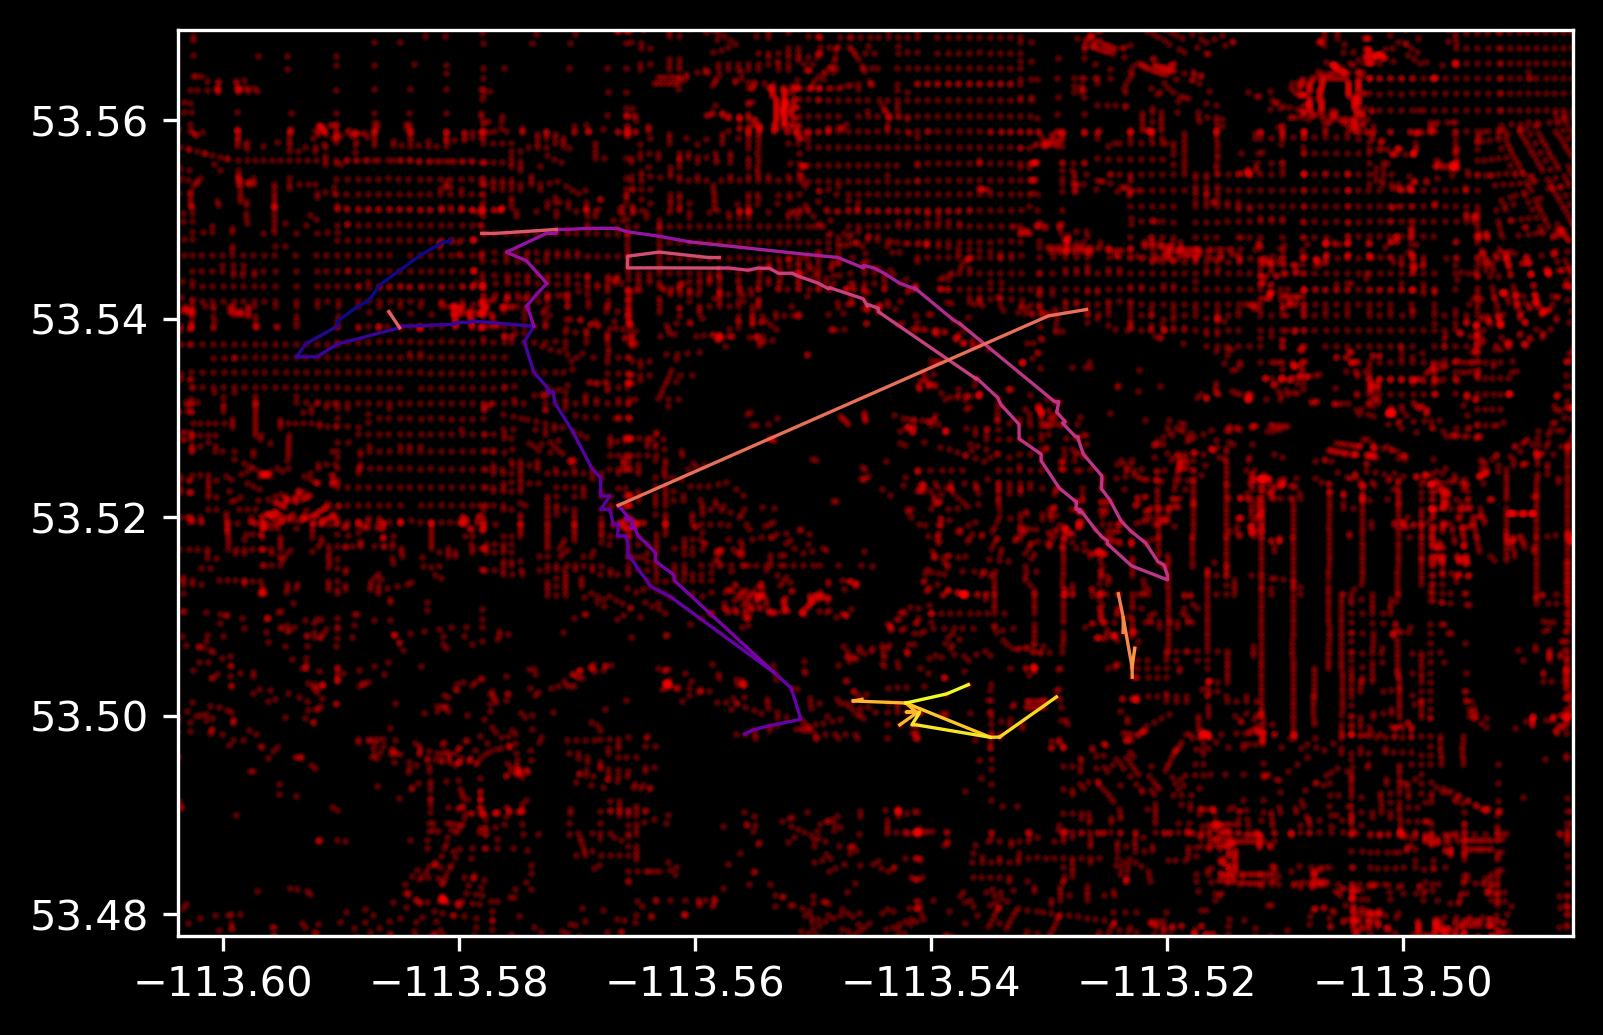

In [968]:
cmaps = cmap.plasma(np.linspace(0,1,len(segs)))
i=0
drawx = yeg.xmap[filt]
drawy = yeg.ymap[filt]

#plt.figure()
fig, ax = plt.subplots()
ax.scatter(yeg.xmap, yeg.ymap, s=1,alpha=0.2,c='r')

for s in seg_ids:
    ax.plot(yeg.xmap[np.array(s)], yeg.ymap[np.array(s)],
            lw=0.8, color=cmaps[i])
    i+=1

#plt.xlim([0.3,0.5])
#plt.ylim([0,0.4])
#ax.set_aspect(1)
#plt.axis('off')
plt.xlim([min(drawx)-0.01, max(drawx)+0.01])
plt.ylim([min(drawy)-0.02, max(drawy)+0.02])

plt.show()

In [969]:
def get_route(ids, mymap):
    #make the graph undirected for finding shortest distance
    G = mymap.graph.to_undirected()
    #get the osm ids for selected nodes
    subnodes = mymap.nodes.iloc[ids]
    sub_idlist = subnodes.index.to_list()
    #create a mas of ids to select on the intermediate nodes in the path
    osm_arr = np.array(mymap.nodes.index)
    mask_ids = []
    edge_ids = []
    for i in range(len(sub_idlist)-1):
        source = sub_idlist[i]
        target = sub_idlist[i+1]
        try:
            shortest_path = nx.shortest_path(G,
                                        source = source,
                                        target = target,
                                        weight = 'length')
        except:
            print ('no path found, moving on')
            continue
        # Step 3: Extract the selected edges' attributes forming the shortest path from the NetworkX graph
        
        for n in shortest_path:
            idx = np.where(osm_arr==n)[0]
            assert len(idx)==1, "More than one OSM id is ambiguious"
            mask_ids.append(idx[0])
        
        path_edges = [(shortest_path[j], shortest_path[j + 1]) for j in range(len(shortest_path) - 1)]
        edge_ids += path_edges
        
    return mask_ids, edge_ids

def get_osmid(mymap, node_mask, edge_ids, filename):
    node_ids = np.where(node_mask)[0]
    subnodes = mymap.nodes.iloc[node_ids]
    node_osm = subnodes.index.to_list()
    node_arr = np.array(node_osm)
    
    edge_arr = np.array(edge_ids)
    
    np.savez_compressed(filename, node_osm=node_arr, edge_osm=edge_arr)
    return None

# Start finding routes

In [970]:
osm_arr = np.array(yeg.nodes.index)
node_mask = np.repeat(False, len(osm_arr))
totseg = len(seg_ids)
#initialize an empty subgraph
edge_ids = []
for i,s in enumerate(seg_ids):
    print (f"\rProcessing segment: {i+1}/{totseg}", end="\r")
    mask, eids = get_routev1(np.array(s),yeg)
    #print (mask)
    node_mask[mask] = True
    edge_ids += eids

In [971]:
artfile = input("Type Output Filename: ")

Type Output Filename: penguin_v00.npz


In [972]:
get_osmid(yeg, node_mask, edge_ids, artfile)

In [973]:
node_ids = np.where(node_mask)[0]
subnodes = yeg.nodes.iloc[node_ids]
node_attr = subnodes.to_dict(orient='index')

In [974]:
for node_id in subgraph.nodes():
    t = node_id in node_attr
    assert t, "Node Id not present"
    subgraph.nodes[node_id].update(node_attr[node_id])

In [975]:
graph_attrs = {'crs': 'epsg:4326', 'simplified': True}
#subgraph = ox.graph_from_gdfs(subnodes, subedges, graph_attrs)

subgraph.graph.update(graph_attrs)

In [976]:
#artfile = 'dolphin_v0.npz'
osmids = np.load(artfile)

In [977]:
node_ids = osmids['node_osm']
node_index = list(node_ids)

edge_ids = osmids['edge_osm']

In [978]:
subnodes = yeg.nodes.loc[node_index]

In [979]:
#check for swapped edge ids
edge_index = []
allidx = yeg.edges.index
for idx in edge_ids:
    if (idx[0], idx[1], 0) in allidx:
        edge_index.append((idx[0], idx[1], 0))
    elif (idx[1], idx[0], 0) in allidx:
        edge_index.append((idx[1], idx[0], 0))
    elif (idx[0], idx[1], 1) in allidx:
        edge_index.append((idx[0], idx[1], 1))
    elif (idx[1], idx[0], 1) in allidx:
        edge_index.append((idx[1], idx[0], 1))
    else:
        print ("Still not in index")

Still not in index
Still not in index


In [980]:
subedges = yeg.edges.loc[edge_index]

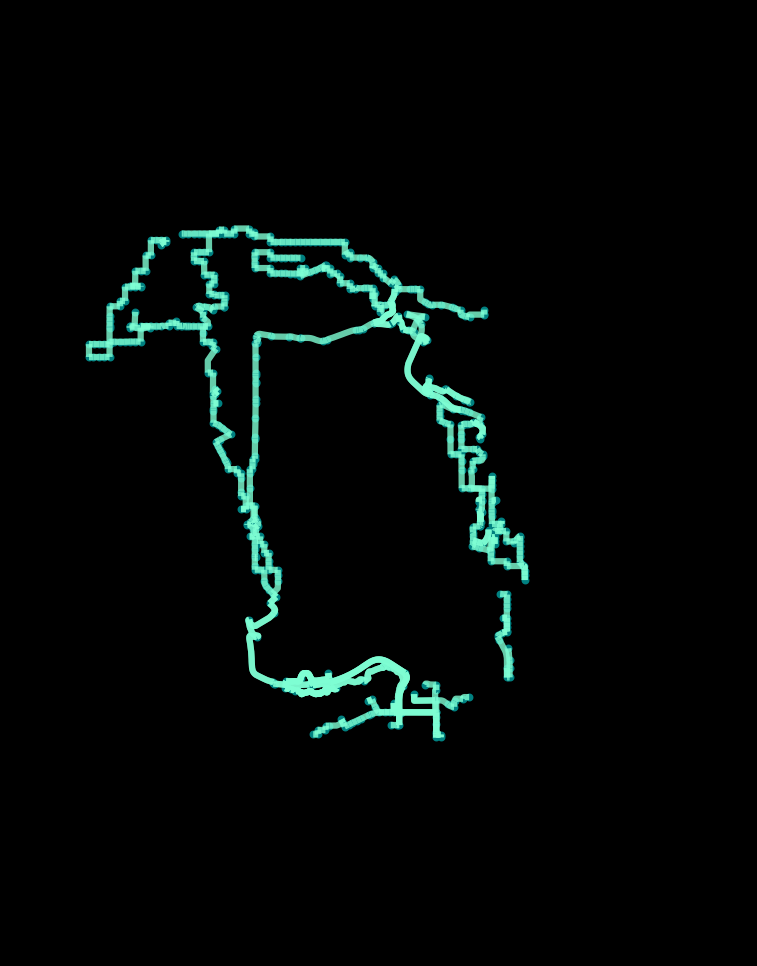

In [981]:
plt.style.use('dark_background')

fig, ax = plt.subplots()

#yeg.edges.plot(ax=ax, edgecolor='grey', alpha=0.7, linewidth=0.5)
subedges.plot(ax=ax, edgecolor='aquamarine', zorder=5, alpha=0.8)
subnodes.plot(ax=ax, color='teal', markersize=0.8)

ax.set_xlim([min(drawx)-0.01, max(drawx)+0.01])
ax.set_ylim([min(drawy)-0.02, max(drawy)+0.02])
plt.axis('off')

plt.show()

# ----------------------------- Legacy Codes --------------------------------